<a href="https://colab.research.google.com/github/BaseKan/aiday_training_resources/blob/main/TF_ConvNets/ConvNets_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductie


In [2]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Dataset

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(train_dir, d))]

We splitsen de validatieset in een validatieset en een testset.


In [5]:
for cl in classes:
  img_path = os.path.join(val_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  val, test = images[:round(len(images)*0.5)], images[round(len(images)*0.5):]

  for t in test:
    if not os.path.exists(os.path.join(base_dir, 'test', cl)):
      os.makedirs(os.path.join(base_dir, 'test', cl))
    shutil.move(t, os.path.join(base_dir, 'test', cl))

cats: 500 Images
dogs: 500 Images


In [5]:
print("{}: {} train images".format(classes[0], len(os.listdir(os.path.join(train_dir, classes[0])))))
print("{}: {} train images".format(classes[1], len(os.listdir(os.path.join(train_dir, classes[1])))))
print("{}: {} validation images".format(classes[0], len(os.listdir(os.path.join(val_dir, classes[0])))))
print("{}: {} validation images".format(classes[1], len(os.listdir(os.path.join(val_dir, classes[1])))))
print("{}: {} test images".format(classes[0], len(os.listdir(os.path.join(test_dir, classes[0])))))
print("{}: {} test images".format(classes[1], len(os.listdir(os.path.join(test_dir, classes[1])))))

cats: 1000 train images
dogs: 1000 train images
cats: 250 validation images
dogs: 250 validation images
cats: 250 test images
dogs: 250 test images


Creating an Image Data Generator

In [6]:
batch_size = 32
IMG_SHAPE = 150

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
image_gen = ImageDataGenerator(rescale=1/255)

train_data_gen = image_gen.flow_from_directory(directory = train_dir, 
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               batch_size = batch_size,
                                               shuffle = True)

Found 2000 images belonging to 2 classes.


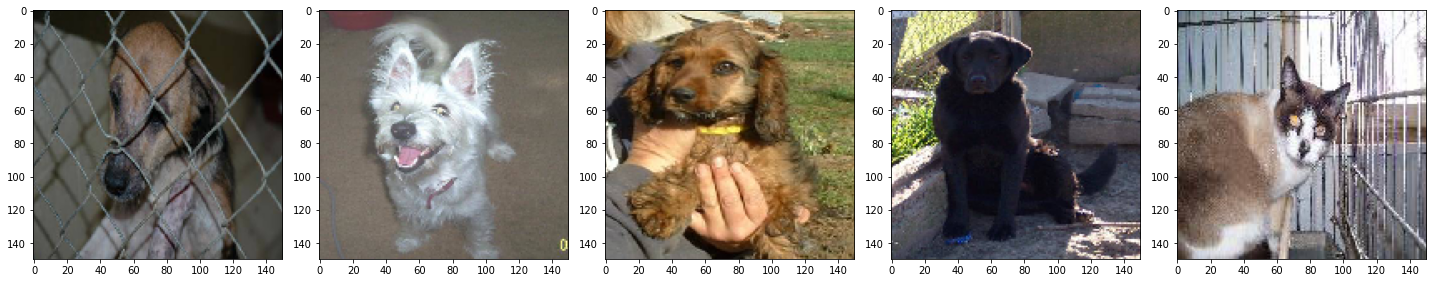

In [9]:
images = [train_data_gen[0][0][i] for i in range(5)]
plotImages(images)

# Exercise

Gebruik de documentatie van [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) om meerdere augmentaties te combineren. Train vervolgens een CNN en probeer een zo goed mogelijke score te halen op de test set.

In [10]:
image_gen_val = ImageDataGenerator(rescale=1/255)

val_data_gen = image_gen_val.flow_from_directory(directory = val_dir,
                                                 target_size = (IMG_SHAPE, IMG_SHAPE),
                                                 batch_size = batch_size)

image_gen_test = ImageDataGenerator(rescale=1/255)

test_data_gen = image_gen_test.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
                                                   batch_size = batch_size)

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [15]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen.flow_from_directory(directory = train_dir, 
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               shuffle = True,
                                               batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [16]:
model = tf.keras.Sequential([
                             Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
                             MaxPooling2D((2,2)),

                             Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                             MaxPooling2D((2,2)),

                             Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                             MaxPooling2D((2,2)),

                             Conv2D(128, (3,3), activation='relu'),
                             MaxPooling2D(2,2),

                             Dropout(0.5),
                             Flatten(),
                             Dense(512, activation='relu'),

                             Dense(len(classes))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

In [13]:
tf.keras.backend.clear_session()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = ['accuracy']
model.compile(
  optimizer=adam_optimizer,
  loss=binary_cross_entropy_loss,
  metrics=accuracy)

history = model.fit(train_data_gen,
                    epochs=100,
                    validation_data=val_data_gen
                    )

Epoch 1/100
63/63 [==============================] - 39s 135ms/step - loss: 0.6903 - accuracy: 0.5320 - val_loss: 0.6693 - val_accuracy: 0.6140
Epoch 2/100
63/63 [==============================] - 8s 127ms/step - loss: 0.6595 - accuracy: 0.6105 - val_loss: 0.6349 - val_accuracy: 0.6520
Epoch 3/100
63/63 [==============================] - 8s 127ms/step - loss: 0.6079 - accuracy: 0.6700 - val_loss: 0.5962 - val_accuracy: 0.6840
Epoch 4/100
63/63 [==============================] - 8s 128ms/step - loss: 0.5509 - accuracy: 0.7270 - val_loss: 0.5766 - val_accuracy: 0.7100
Epoch 5/100
63/63 [==============================] - 8s 127ms/step - loss: 0.5128 - accuracy: 0.7495 - val_loss: 0.5884 - val_accuracy: 0.6820
Epoch 6/100
63/63 [==============================] - 8s 127ms/step - loss: 0.4915 - accuracy: 0.7600 - val_loss: 0.5900 - val_accuracy: 0.6680
Epoch 7/100
63/63 [==============================] - 8s 128ms/step - loss: 0.4598 - accuracy: 0.7790 - val_loss: 0.5485 - val_accuracy: 0.716

In [14]:
model.evaluate(test_data_gen)

16/16 [==============================] - 2s 93ms/step - loss: 1.4147 - accuracy: 0.7400


[1.414656162261963, 0.7400000095367432]

In [ ]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(len(classes))
])

model.summary()

In [ ]:
tf.keras.backend.clear_session()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = ['accuracy']
model.compile(
  optimizer=adam_optimizer,
  loss=cross_entropy_loss,
  metrics=accuracy)

history = model.fit(train_data_gen, epochs=100,validation_data=val_data_gen)